In [29]:
import pandas as pd
import numpy as np
import cv2
import sys
import importlib
SEED = 1234
np.random.seed(SEED) 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, AveragePooling2D, Concatenate, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
import mylibs.ResNet as ResNet
import mylibs.SENet as SENet
importlib.reload(ResNet)
importlib.reload(SENet)
from keras.models import Model

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter

In [2]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session  
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True
# set_session(tf.Session(config=config)) 

In [3]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [4]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [5]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [6]:
use_custom_augmentation = False
if use_custom_augmentation:
    df_train = pd.read_json('E:/kaggle/iceberg/train.json/data/processed/train.json')
    df_test = pd.read_json('E:/kaggle/iceberg/test.json/data/processed/test.json')
    Xtrain = get_scaled_imgs(df_train)
    Xtest = get_scaled_imgs(df_test)
    Ytrain = np.array(df_train['is_iceberg'])
    
    df_train["inc_angle"] = df_train["inc_angle"].replace('na',0)
    df_test["inc_angle"] = df_test["inc_angle"].replace('na',0)
    idx_tr = np.where(df_train["inc_angle"]>0)
    Xtrain = Xtrain[idx_tr[0]]
    Ytrain = Ytrain[idx_tr[0]]
    
    Xtrain = get_more_images(Xtrain) 
    Ytrain = np.concatenate((Ytrain,Ytrain,Ytrain, Ytrain))
else:
    train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
    target_train=train['is_iceberg']
    test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")
    
    train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
    test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
    train['inc_angle']=train['inc_angle'].fillna(method='pad')
    test['inc_angle']=test['inc_angle'].fillna(method='pad')
    X_angle=train['inc_angle']
    X_test_angle=test['inc_angle']
    
    #Generate the training data
    X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
    X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
    #apply filter
    X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
    X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
    X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
    X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
    X_band_1 = X_band_1_filtered
    X_band_2 = X_band_2_filtered

    X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
    X_band_4=np.maximum(X_band_1,X_band_2)
    X_band_5=np.minimum(X_band_1,X_band_2)
    X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)

    X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
    X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
    #apply filter
    X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
    X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
    X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
    X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
    X_band_test_1 = X_band_test_1_filtered
    X_band_test_2 = X_band_test_2_filtered

    X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
    X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
    X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
    X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)
    
    X_train = get_more_images(X_train)
    target_train = np.concatenate((target_train, target_train, target_train, target_train))
    X_angle = np.concatenate((X_angle, X_angle, X_angle, X_angle))
    
    Xtrain = X_train
    Ytrain = target_train
    Xtest = X_test
    Xangle = X_angle
    Xangle_test = X_test_angle
    df_train = train
    df_test = test

In [7]:
print(Xtrain.shape, Ytrain.shape, Xangle.shape, Xtest.shape)

(6416, 75, 75, 3) (6416,) (6416,) (8424, 75, 75, 3)


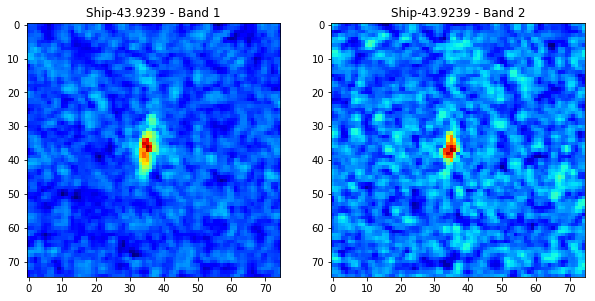

In [8]:
display_img(X_band_1[0], X_band_2[0], target_train[0], X_angle[0])

In [30]:
# VGG16, ResNet50, SENet50
baseModelName = "ResNet18"
useAngle = False
def getModel(baseModelName):
    global useAngle
    angle_input = Input(shape=[1], name="angle")
    angle_layer = Dense(1)(angle_input)
    if baseModelName == "VGG16":
        baseModel = VGG16(weights='imagenet', include_top=False, input_shape=Xtrain.shape[1:], pooling = "avg")
        cnnOutput = baseModel.output
    elif baseModelName == "ResNet50":
        baseModel = ResNet.ResNet50(weights='imagenet', include_top=False, input_shape=Xtrain.shape[1:], pooling = "avg")
        cnnOutput = baseModel.output
#         cnnOutput = baseModel.get_layer("final").output
#         cnnOutput = AveragePooling2D((3, 3), name='avg_pool')(cnnOutput)
#         cnnOutput = GlobalAveragePooling2D(name = "global_avg_pool")(cnnOutput)
    elif baseModelName == "SENet50":
        baseModel = SENet.SENet50(weights='imagenet', include_top=False, input_shape=Xtrain.shape[1:], pooling = "avg",
#                                   kernel_regularizer = "l2",
#                                   bias_regularizer = "l2",
#                                   activity_regularizer = None,
#                                   regularizer_value = 1e-4
                                 )
#         cnnOutput = baseModel.output
        cnnOutput = baseModel.get_layer("final").output
        cnnOutput = AveragePooling2D((3, 3), name='avg_pool')(cnnOutput)
        cnnOutput = GlobalAveragePooling2D(name = "global_avg_pool")(cnnOutput)
    elif baseModelName == "ResNet18":
        baseModel = ResNet.ResNet18(weights='imagenet', include_top=False, input_shape=Xtrain.shape[1:])
        cnnOutput = baseModel.get_layer("final").output

    if baseModelName == "VGG16":
        fcOutput = Dropout(0.6)(cnnOutput)
        predictions = Dense(1, activation="sigmoid")(fcOutput)
        model = Model(inputs=baseModel.input, outputs=predictions)
    elif baseModelName == "ResNet50":
        useAngle = True
        predictions = Dense(1, activation="sigmoid")(Concatenate()([Dropout(0.6)(cnnOutput), angle_layer]))
        model = Model(inputs=[baseModel.input, angle_input], outputs=predictions)
    elif baseModelName == "SENet50":
        predictions = Dense(1, activation="sigmoid")(cnnOutput)
        model = Model(inputs=baseModel.input, outputs=predictions)
    elif baseModelName == "ResNet18":
        useAngle = True
        cnnOutput = Dropout(0.6)(Flatten()(cnnOutput))
        predictions = Dense(1, activation="sigmoid")(Concatenate()([cnnOutput, angle_layer]))
        model = Model(inputs=[baseModel.input, angle_input], outputs=predictions)
    
    optimizer = Adam(lr=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [31]:
model = getModel(baseModelName)
model.summary()
plot_model(model, to_file=baseModelName.lower() + ".png")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 38, 38, 16)    2368        input_10[0][0]                   
____________________________________________________________________________________________________
activation_217 (Activation)      (None, 38, 38, 16)    0           conv1[0][0]                      
____________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D)  (None, 18, 18, 16)    0           activation_217[0][0]             
___________________________________________________________________________________________

In [ ]:
# for layer in model.layers:
#     print(layer.name, layer.trainable)

In [11]:
# if sys.version_info[1] == 5:
#     batch_size = 32
# else:
#     batch_size = 64
batch_size = 64
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=8, verbose=1, epsilon=1e-4, mode='min')
tensorboard = TensorBoard(log_dir='./logs')

In [32]:
K=3
epochs = 100
Kfolds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED).split(Xtrain, Ytrain))
y_test_pred_log = 0
for j, (train_idx, test_idx) in enumerate(Kfolds):
    print('\n===================FOLD=',j)
    Xtrain_cv = Xtrain[train_idx]
    Ytrain_cv = Ytrain[train_idx]
    Xangle_cv = Xangle[train_idx]
    Xtrain_val = Xtrain[test_idx]
    Ytrain_val = Ytrain[test_idx]
    Xangle_val = Xangle[test_idx]
    
    model_file = 'model_%s_%s.hdf5' % (baseModelName.lower(), j)
    
    mcp_save = ModelCheckpoint(model_file, save_best_only=True, monitor='val_loss', mode='min')
    model = getModel(baseModelName)
    
    if useAngle:
        Xtrain_cv = [Xtrain_cv, Xangle_cv]
        Xtrain_val = [Xtrain_val, Xangle_val]
        Xtrain_input = [Xtrain, Xangle]
        Xtest_input = [Xtest, Xangle_test]
    else:
        Xtrain_input = Xtrain
        Xtest_input = Xtest
        
    model.fit(Xtrain_cv, Ytrain_cv, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True, callbacks=[
        earlyStopping, 
        mcp_save, 
        reduce_lr_loss, 
#       tensorboard  
    ], validation_data=(Xtrain_val, Ytrain_val))
    
    model.load_weights(filepath = model_file)    
    
    score = model.evaluate(Xtrain_input, Ytrain, verbose=1)
    print('Train score:', score[0])
    print('Train accuracy:', score[1])
    y_test_pred_log += model.predict(Xtest_input).reshape(Xtest.shape[0])
    
y_test_pred_log /= K


===================FOLD= 0
Train on 4277 samples, validate on 2139 samples
Epoch 1/100
4277/4277 [==============================] - 73s - loss: 1.9478 - acc: 0.5155 - val_loss: 1.3617 - val_acc: 0.5306
Epoch 2/100
4277/4277 [==============================] - 15s - loss: 1.2048 - acc: 0.5417 - val_loss: 1.0651 - val_acc: 0.530660 - acc
Epoch 3/100
4277/4277 [==============================] - 16s - loss: 0.9607 - acc: 0.5558 - val_loss: 0.9110 - val_acc: 0.5306
Epoch 4/100
4277/4277 [==============================] - 16s - loss: 0.8025 - acc: 0.5756 - val_loss: 0.7899 - val_acc: 0.5302
Epoch 5/100
4277/4277 [==============================] - 16s - loss: 0.7149 - acc: 0.6025 - val_loss: 0.6716 - val_acc: 0.5259
Epoch 6/100
4277/4277 [==============================] - 16s - loss: 0.6923 - acc: 0.6081 - val_loss: 0.6095 - val_acc: 0.5484
Epoch 7/100
4277/4277 [==============================] - 16s - loss: 0.6790 - acc: 0.6049 - val_loss: 0.5885 - val_acc: 0.6045
Epoch 8/100
4277/4277 [====

4277/4277 [==============================] - 15s - loss: 0.2244 - acc: 0.9041 - val_loss: 0.3426 - val_acc: 0.8728
Epoch 63/100
4277/4277 [==============================] - 15s - loss: 0.2115 - acc: 0.9114 - val_loss: 0.3796 - val_acc: 0.8719
Epoch 64/100
4277/4277 [==============================] - 15s - loss: 0.2118 - acc: 0.9135 - val_loss: 0.3064 - val_acc: 0.8887
Epoch 65/100
4277/4277 [==============================] - 15s - loss: 0.2059 - acc: 0.9156 - val_loss: 0.3140 - val_acc: 0.8799
Epoch 66/100
4277/4277 [==============================] - 15s - loss: 0.2155 - acc: 0.9102 - val_loss: 0.2883 - val_acc: 0.8822
Epoch 67/100
4224/4277 [============================>.] - ETA: 0s - loss: 0.2078 - acc: 0.9122
Epoch 00066: reducing learning rate to 1.5999999595806004e-05.
4277/4277 [==============================] - 15s - loss: 0.2079 - acc: 0.9119 - val_loss: 0.2738 - val_acc: 0.8827
Epoch 68/100
4277/4277 [==============================] - 15s - loss: 0.2152 - acc: 0.9133 - val_los

KeyboardInterrupt: 

In [ ]:
tensorboard.writer.close()

In [ ]:
submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': y_test_pred_log})
print(submission.head(10))
print(submission.count(), Xtest.shape[0])

submission.to_csv('submission-cnn-custom-%s.csv' % baseModelName, index=False)